In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import QiskitRuntimeService

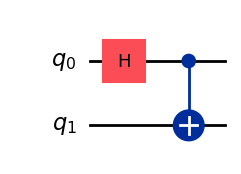

In [2]:
## creates a quantum circuit with 2 qubits
qc = QuantumCircuit(2) 

## adds a hardamard gate to qubit 0
qc.h(0)

#perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.cx(0,1)

# return the drawing of the circuit using matplotlib ('mpl'), remove the mpl argument to get a text drawing
qc.draw('mpl')

In [4]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
# Save an IBM Quantum account and set it as your default account.
QiskitRuntimeService.save_account(
    channel="ibm_quantum",
    token="d4498df8ce80461dfde782857605eda2698b756f556e6abc90906abfed8e1c4adcf933c4bc7b77a2fe3c8e1f073c78ee493d2696f826c1dff8a981da8f612396",
    set_as_default=True,
    # Use `overwrite=True` if you're updating your token.
    overwrite=True,
)
 
# Load saved credentials
service = QiskitRuntimeService()

This example measure expectation values by using the qiskit.quantum_info submodule which is specified by using operators. The following code cell creates six two qubit pauli operators.

Here something like ZZ operator is shorthand for the tensor product Z x Z which means measuring Z on qubit 1 and Z on qubit 0 together. 

If the state is entangled the measurement of z1,z0 should be 1.

In [6]:
# Set up six different observables.
from qiskit.quantum_info import SparsePauliOp
 
observables_labels = ["IZ", "IX", "ZI", "XI", "ZZ", "XX"]
observables = [SparsePauliOp(label) for label in observables_labels]

Qiskit provides two ways to return data:
 
 You can obtain a probability distribution for a set of qubits you choose to measure.
    OR 
You can obtain the expectation value of an observable. 

You measure you circuit in one of these two ways with Qiskit primitivies. Which will be explained in detail later.

Optimizinng the Circuit in the below code block:

When executing citcuits on a device it is important to optimize the set of instructions that the circuit contains and minimize the overall depth. This ensures that you obtain the best results possible by reducing the effects of error and noise. 

The circuit must also conform to a backend device's instruction set architecture (https://docs.quantum.ibm.com/guides/transpile#instruction-set-architecture) and must consider the devices basis gates and qubit connectivity. 

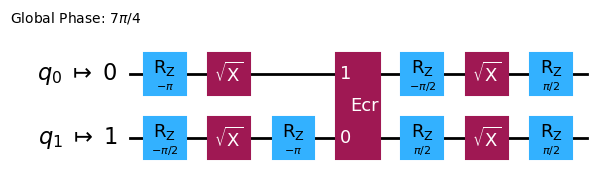

In [7]:
backend = service.least_busy(simulator=False, operational=True)
 
# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
 
isa_circuit.draw('mpl', idle_wires=False)

Quantum computers can produce random results, so you usually collect a sample of outputs by running the circuit many times. You can estimaate the value of the observable by using the Estimator class. 

Estimator is one of two primitives (as mentioned above). The other is Sampler.

Sampler

The Sampler is used to compute sampling probabilities of quantum circuits. Given a quantum circuit, the sampler runs the circuit and returns the probability distribution of measuring different outcomes. It's typically used when you're interested in understanding the frequency of different measurement results.

Estimator
The Estimator, on the other hand, computes expectation values of quantum observables. It takes a quantum circuit and a set of observables (typically Hermitian operators) as input and outputs the expected value of these observables after applying the quantum circuit.

In [8]:
# Construct the Estimator instance.
from qiskit_ibm_runtime import EstimatorV2 as Estimator
 
estimator = Estimator(mode=backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 5000
 
mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]
 
# One pub, with one circuit to run against five different observables.
job = estimator.run([(isa_circuit, mapped_observables)])
 
# Use the job ID to retrieve your job data later
print(f">>> Job ID: {job.job_id()}")

>>> Job ID: cvj8yr3vawwg0089hxrg


In [9]:
job_result = job.result() ## retrieve job resilts 
pub_result = job.result()[0]

In [13]:
job_result

PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(6,), dtype=float64>), stds=np.ndarray(<shape=(6,), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(6,), dtype=float64>), shape=(6,)), metadata={'shots': 5024, 'target_precision': 0.01414213562373095, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 32})], metadata={'dynamical_decoupling': {'enable': False, 'sequence_type': 'XX', 'extra_slack_distribution': 'middle', 'scheduling_method': 'alap'}, 'twirling': {'enable_gates': False, 'enable_measure': True, 'num_randomizations': 'auto', 'shots_per_randomization': 'auto', 'interleave_randomizations': True, 'strategy': 'active-accum'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': False, 'pec_mitigation': False}, 'version': 2})

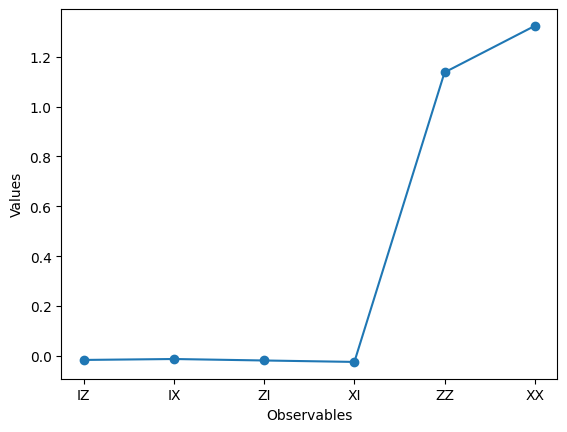

In [12]:
from matplotlib import pyplot as plt

values = pub_result.data.evs
errors = pub_result.data.stds

## plot pub_results 
plt.plot(observables_labels, values, '-o')
plt.xlabel('Observables')
plt.ylabel('Values')
plt.show()